Notebook Sections

Introduction & Setup

State the purpose: define, train, and evaluate the classification model.
Import necessary libraries: tensorflow, keras, sklearn.metrics, matplotlib.pyplot, os.
Load the data generators prepared in the previous notebook.

In [ ]:
import tensorflow as tf
from keras._tf_keras.keras.models import Sequential, load_model
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras._tf_keras.keras.applications import MobileNetV2, ResNet50V2 # Example pre-trained models
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# Re-import or load generators from previous notebook's output
# (In a real notebook, you might re-run data_loader.py or simply instantiate generators)
# For demonstration, we'll assume the setup from 1.0 is available or we re-define minimal parts
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
PROCESSED_DATA_DIR = 'data/processed'
TRAIN_DIR = os.path.join(PROCESSED_DATA_DIR, 'train')
VAL_DIR = os.path.join(PROCESSED_DATA_DIR, 'validation')
TEST_DIR = os.path.join(PROCESSED_DATA_DIR, 'test')

# Re-create simple generators for this notebook's context if not running sequentially
train_datagen_simple = ImageDataGenerator(rescale=1./255) # No augmentation for simplicity in re-creating
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen_simple.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)
validation_generator = val_test_datagen.flow_from_directory(VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_generator = val_test_datagen.flow_from_directory(TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

NUM_CLASSES = train_generator.num_classes
CLASS_NAMES = list(train_generator.class_indices.keys())

NameError: name 'ImageDataGenerator' is not defined

Model Definition

Define your CNN architecture. For image classification, transfer learning is highly recommended.
Load a pre-trained model (e.g., MobileNetV2, ResNet50V2, VGG16) without its top (classification) layers.
Freeze the layers of the pre-trained base model to retain its learned features.
Add your own custom classification head (e.g., Flatten, Dense layers with relu activation, Dropout, and a final Dense layer with softmax activation for multiclass classification).
Compile the model: Choose an optimizer (e.g., Adam), loss function (categorical_crossentropy for one-hot encoded labels), and metrics (accuracy).

In [ ]:
def build_transfer_model(input_shape, num_classes):
    # Load pre-trained MobileNetV2 model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    base_model.trainable = False

    # Create a new model on top
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5), # Add dropout for regularization
        Dense(num_classes, activation='softmax') # Output layer
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_transfer_model(IMG_SIZE + (3,), NUM_CLASSES) # (224, 224, 3)
model.summary()

Model Training

Train the model using the fit() or fit_generator() method.
Implement callbacks for better training control:
ModelCheckpoint: Save the best model weights based on validation accuracy.
EarlyStopping: Stop training if validation accuracy doesn't improve for a certain number of epochs (patience).
ReduceLROnPlateau: Reduce learning rate if validation accuracy plateaus.

In [ ]:
EPOCHS = 30 # You might need more or less depending on your data and model

# Define callbacks
callbacks = [
    ModelCheckpoint(filepath='trained_models/best_waste_classifier.h5',
                    monitor='val_accuracy',
                    save_best_only=True,
                    verbose=1),
    EarlyStopping(monitor='val_accuracy',
                  patience=5, # Stop if no improvement for 5 epochs
                  restore_best_weights=True,
                  verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy',
                      factor=0.2, # Reduce learning rate by a factor of 0.2
                      patience=3, # If no improvement for 3 epochs
                      verbose=1,
                      min_lr=1e-6)
]

print("\nStarting model training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks
)

print("\nTraining complete! Saving final model...")
model.save('trained_models/final_waste_classifier.h5')

# Save training history
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('trained_models/training_history.csv', index=False)

Training Visualization

Plot the training and validation accuracy over epochs.
Plot the training and validation loss over epochs.
These plots help identify overfitting/underfitting and optimal training duration.

NameError: name 'history' is not defined

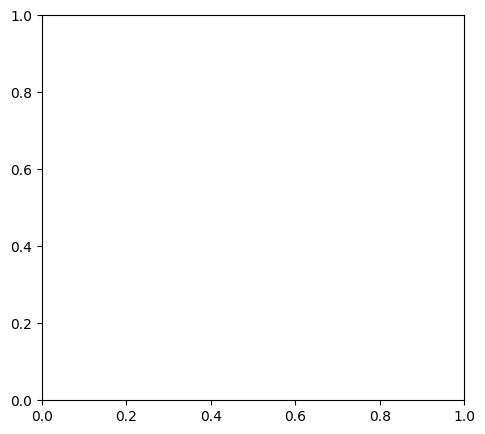

In [2]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

Model Evaluation on Test Set

Evaluate the final (or best saved) model on the unseen test set.
Generate a classification report (precision, recall, F1-score for each class).
Generate and display a confusion matrix. This is critical for understanding misclassifications.
Show sample misclassified images to gain visual intuition about why the model made errors.

In [3]:
# Load the best model saved during training
best_model = load_model('trained_models/best_waste_classifier.h5')

print("\nEvaluating model on the test set...")
loss, accuracy = best_model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions
test_generator.reset() # Important to reset generator for consistent predictions
y_pred_probs = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = test_generator.classes # True labels from generator

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=CLASS_NAMES))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# (Optional) Show misclassified examples
misclassified_indices = np.where(y_true_classes != y_pred_classes)[0]
if len(misclassified_indices) > 0:
    print("\nDisplaying a few misclassified images:")
    plt.figure(figsize=(12, 10))
    for i, idx in enumerate(misclassified_indices[:9]): # Show up to 9 misclassified images
        img_path = test_generator.filepaths[idx]
        img = plt.imread(img_path)
        true_label = CLASS_NAMES[y_true_classes[idx]]
        predicted_label = CLASS_NAMES[y_pred_classes[idx]]

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'trained_models/best_waste_classifier.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Conclusion

Summarize the model's performance, highlighting its strengths and weaknesses.
Briefly mention the next steps (deeper analysis in notebook 3.0).